In [112]:
#Importing and packages management logistics
import pandas as pd
import numpy as np
import scipy as sp
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

import pandas_profiling as p2
import seaborn as sb
import itertools
from mpl_toolkits.mplot3d import Axes3D
from scipy.spatial.distance import cdist

from sklearn.model_selection import train_test_split, learning_curve, ShuffleSplit, cross_validate, cross_val_score, validation_curve
from sklearn.metrics import accuracy_score, f1_score, classification_report, cohen_kappa_score, mean_squared_error, confusion_matrix, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn import neighbors, datasets, linear_model
from sklearn.model_selection import GridSearchCV, cross_val_score, KFold, learning_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.utils import resample

import os
from sklearn.tree import export_graphviz
import graphviz
from IPython.display import Image
from sklearn.externals.six import StringIO
import pydotplus

In [113]:
#Plot confusion matrices and learning curves
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion Matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized Confusion Matrix")
    else:
        print('Confusion Matrix, without Normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=0)
    plt.yticks(tick_marks, classes)

    fmt = '.4f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    
def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, scoring=None,
                        n_jobs=1, train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training Examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes, scoring=scoring)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()

    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,
                     color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
             label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
             label="Validation score")

    plt.legend(loc="best")
    return plt

In [114]:
#Read data
d = pd.read_excel('Credit_card_data.xls', header = 1)
d = pd.DataFrame(d)

#Calculate amount of credit remaining in September - 'Remain'
d['Remain'] = (d.LIMIT_BAL - d.BILL_AMT1) / d.LIMIT_BAL

#New variables
d["ifDefault"] = 1
d.loc[(d['PAY_0'] < 1 )&(d['PAY_2']<1)&(d['PAY_3']< 1)&(d['PAY_4']< 1)&(d['PAY_5'] < 1)&(d['PAY_6']< 1),'ifDefault'] = 0
d["PBratio"] = d[['PAY_AMT1','PAY_AMT2','PAY_AMT3','PAY_AMT4','PAY_AMT5','PAY_AMT6']].sum(axis=1)/(d[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].sum(axis=1)+0.01)
d["BLratio"] = d[['BILL_AMT1','BILL_AMT2','BILL_AMT3','BILL_AMT4','BILL_AMT5','BILL_AMT6']].mean(axis=1)/d["LIMIT_BAL"]

#Transformations to create normality
d.LIMIT_BAL = np.cbrt(d.LIMIT_BAL)
d.AGE = np.log(d.AGE+0.001)
d.BILL_AMT1 = np.cbrt(d.BILL_AMT1)
d.BILL_AMT2 = np.cbrt(d.BILL_AMT2)
d.BILL_AMT3 = np.cbrt(d.BILL_AMT3)
d.BILL_AMT4 = np.cbrt(d.BILL_AMT4)
d.BILL_AMT5 = np.cbrt(d.BILL_AMT5)
d.BILL_AMT6 = np.cbrt(d.BILL_AMT6)
d.PAY_AMT1 = np.sqrt(d.PAY_AMT1)
d.PAY_AMT2 = np.sqrt(d.PAY_AMT2)
d.PAY_AMT3 = np.sqrt(d.PAY_AMT3)
d.PAY_AMT4 = np.sqrt(d.PAY_AMT4)
d.PAY_AMT5 = np.sqrt(d.PAY_AMT5)
d.PAY_AMT6 = np.sqrt(d.PAY_AMT6)

#Remove 0 and transform categoricals into dummy variables
d = d[d.EDUCATION != 0]
d = d[d.MARRIAGE != 0]
d = d.drop('ID', axis = 1)
d = pd.get_dummies(d, columns=['SEX','EDUCATION','MARRIAGE','PAY_0','PAY_2','PAY_3',
                              'PAY_4','PAY_5','PAY_6'], drop_first=True)

#Set X and Y
X = d.drop('default payment next month', axis = 1)
Y = d['default payment next month']

In [115]:
#Set CV strategies
inner_cv = KFold(n_splits=5, shuffle=True, random_state=42)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)
cv = ShuffleSplit(n_splits=5, test_size=0.25, random_state=42)

#Train-Test Split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

#Sample and rebalance
samp0 = d[d['default payment next month'] == 0]
ind0 = [i for i in samp0.index if i not in X_test.index]
samp0 = samp0[samp0.index.isin(ind0)].sample(n=4750, axis = 0)
samp1 = d[d['default payment next month'] == 1]
ind1 = [i for i in samp1.index if i not in X_test.index]
samp1 = samp1[samp1.index.isin(ind1)].sample(n=4750, axis = 0)
d_samp = samp0.append(samp1)

#Separate sampled and balanced data into X_cv and Y_cv
X_cv = d_samp.drop('default payment next month', axis = 1)
Y_cv = d_samp['default payment next month']

# Decision Tree Model Tuning

Fitting 5 folds for each of 1330 candidates, totalling 6650 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:   12.9s
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:   42.1s
[Parallel(n_jobs=-1)]: Done 2426 tasks      | elapsed:   57.8s
[Parallel(n_jobs=-1)]: Done 3176 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4026 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4976 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 6026 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 6650 out of 6650 | elapsed:  2.8min finished


[[Parameter Tuning - DT]]
Non-nested CV:  0.7061052631578948
Optimal Parameter:  {'max_depth': 5, 'min_samples_leaf': 100, 'min_samples_split': 50}
Optimal Estimator:  DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=100, min_samples_split=50,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='best')

Model Performance: 0.7635974876386477
              precision    recall  f1-score   support

           0     0.8714    0.8178    0.8437      5840
           1     0.4685    0.5709    0.5147      1643

   micro avg     0.7636    0.7636    0.7636      7483
   macro avg     0.6700    0.6944    0.6792      7483
weighted avg     0.7829    0.7636    0.7715      7483

Confusion Matrix, without Normalization
[[4776 1064]
 [ 705  938]]
Normalized Confusion Matrix
[[0.8178 0.1822]
 [0.42

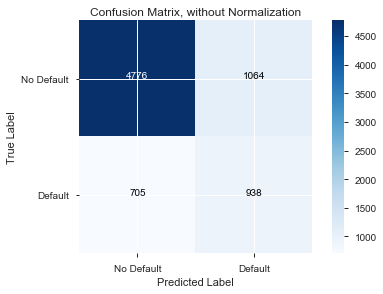

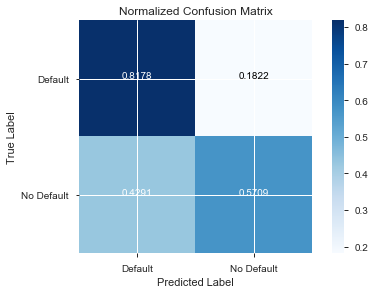

In [116]:
#Decision Tree Model Tuning
min_samples_split = [i for i in range(50,1000,50)]
min_samples_leaf = [i for i in range(50,750,50)]
max_depth = [i for i in range(3,8)]

gs_dt = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42),
                  param_grid=[{'max_depth': max_depth, 'min_samples_leaf':min_samples_leaf,
                              'min_samples_split':min_samples_split}], 
                      scoring='accuracy',
                  cv=inner_cv, n_jobs=-1, verbose = 1)

gs_dt = gs_dt.fit(X_cv,Y_cv)
print("[[Parameter Tuning - DT]]")
print("Non-nested CV: ", gs_dt.best_score_)
print("Optimal Parameter: ", gs_dt.best_params_)
print("Optimal Estimator: ", gs_dt.best_estimator_)

#Decision Tree Evaluation
Y_pred = (gs_dt.best_estimator_.fit(X_cv, Y_cv).predict(X_test))
cm1 = confusion_matrix(Y_test, Y_pred)
print('\nModel Performance: '+str((cm1[0][0]+cm1[1][1])/(np.sum(cm1))))
print(classification_report(Y_test, Y_pred, digits=4))

#Class Probability Estimation
cpe_dt = pd.DataFrame(gs_dt.best_estimator_.fit(X_cv, Y_cv).predict_proba(X_test))
cpe_dt['Actual'] = Y

#max_depth = 5; min_leaf = 50; min_split = 380

#Plot confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=4)

plt.figure()
plot_confusion_matrix(cm, classes=['No Default','Default'], title='Confusion Matrix, without Normalization')

plt.figure()
plot_confusion_matrix(cm, classes=['No Default','Default'], normalize=True, title='Normalized Confusion Matrix')

plt.show()

In [117]:
#Plot plain decision tree
dt_plot = gs_dt.best_estimator_.fit(X, Y)

dot_data = StringIO()
export_graphviz(dt_plot, out_file=dot_data,
                feature_names=X.columns[:], 
                class_names=['0','1'],  
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())


KeyboardInterrupt



# Gradient Boosted Tree* Model Tuning
*As Stochastic Boosted Tree


Model Performance: 0.7315247895229187
              precision    recall  f1-score   support

           0     0.8867    0.7521    0.8139      5840
           1     0.4277    0.6586    0.5186      1643

   micro avg     0.7315    0.7315    0.7315      7483
   macro avg     0.6572    0.7053    0.6662      7483
weighted avg     0.7859    0.7315    0.7490      7483

Confusion Matrix, without Normalization
[[4392 1448]
 [ 561 1082]]
Normalized Confusion Matrix
[[0.7521 0.2479]
 [0.3414 0.6586]]


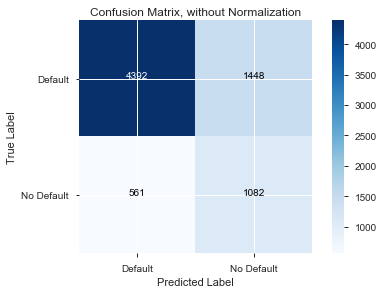

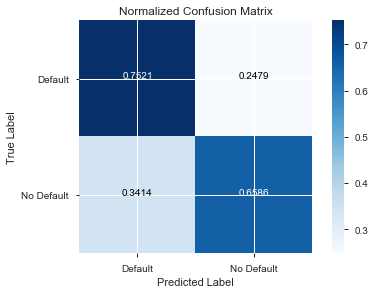

,0
ifDefault,0.123827
PAY_0_2,0.066139
BLratio,0.062741
PBratio,0.060682
Remain,0.050057
BILL_AMT1,0.043128
PAY_AMT1,0.040622
PAY_AMT2,0.040333
PAY_AMT4,0.036298
PAY_AMT3,0.034882


In [119]:
#Gradient Boosted Tree Tuning
eGBT = GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential',
              max_features=30, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_weight_fraction_leaf=0.0, n_estimators=500,
              n_iter_no_change=None, presort='auto', random_state=42,
              subsample=0.65, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False)

#Tree Evaluation
Y_pred_eGBT = (eGBT.fit(X_cv, Y_cv).predict(X_test))
cm1 = confusion_matrix(Y_test, Y_pred_eGBT)
print('\nModel Performance: '+str((cm1[0][0]+cm1[1][1])/(np.sum(cm1))))
print(classification_report(Y_test, Y_pred_eGBT, digits=4))

#Plot confusion matrix
cm = confusion_matrix(Y_test, Y_pred_eGBT)
np.set_printoptions(precision=4)

plt.figure()
plot_confusion_matrix(cm, classes=['No Default','Default'],
                      title='Confusion Matrix, without Normalization')

plt.figure()
plot_confusion_matrix(cm, classes=['No Default','Default'], normalize=True,
                      title='Normalized Confusion Matrix')

plt.show()

#Print List of relative variable importance
imp_rank_GBT = pd.DataFrame(eGBT.feature_importances_)
imp_rank_GBT.index = X_cv.columns
imp_rank_GBT = imp_rank_GBT.sort_values(by = 0, ascending = False)
imp_rank_GBT

# Random Forest Model Tuning


Model Performance: 0.7402111452625952
Random Forest
              precision    recall  f1-score   support

           0     0.8835    0.7685    0.8220      5840
           1     0.4374    0.6397    0.5195      1643

   micro avg     0.7402    0.7402    0.7402      7483
   macro avg     0.6604    0.7041    0.6708      7483
weighted avg     0.7855    0.7402    0.7556      7483

Confusion Matrix, without Normalization
[[4488 1352]
 [ 592 1051]]
Normalized Confusion Matrix
[[0.7685 0.2315]
 [0.3603 0.6397]]


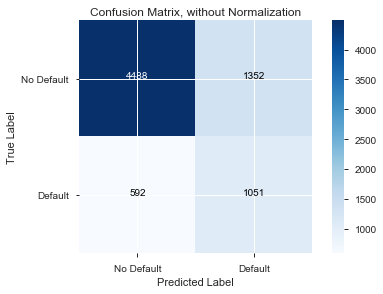

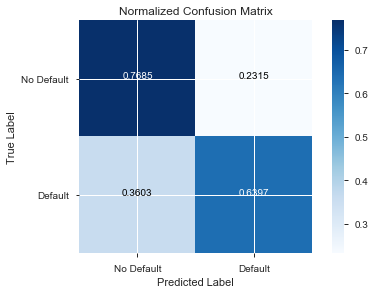

,0
BLratio,5.360247e-02
ifDefault,5.312976e-02
PBratio,5.305558e-02
Remain,5.043086e-02
AGE,4.950043e-02
LIMIT_BAL,4.707773e-02
BILL_AMT1,4.591319e-02
PAY_AMT1,4.287695e-02
BILL_AMT2,4.266437e-02
BILL_AMT3,4.124664e-02


In [125]:
#Random Forest Model Tuning
eRF = RandomForestClassifier(bootstrap=True, class_weight='balanced_subsample',
            criterion='gini', max_features='auto',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_weight_fraction_leaf=0.0,
            n_estimators=1000, n_jobs=None, oob_score=False,
            random_state=42, verbose=0, warm_start=False)

#RF Evaluation
Y_pred_eRF = (eRF.fit(X_cv, Y_cv).predict(X_test))
cm1 = confusion_matrix(Y_test, Y_pred_eRF)
print('\nModel Performance: '+str((cm1[0][0]+cm1[1][1])/(np.sum(cm1))))
print('Random Forest')
print(classification_report(Y_test, Y_pred_eRF, digits=4))

#Plot confusion matrix
cm = confusion_matrix(Y_test, Y_pred_eRF)
np.set_printoptions(precision=4)

plt.figure()
plot_confusion_matrix(cm, classes=['No Default','Default'], title='Confusion Matrix, without Normalization')

plt.figure()
plot_confusion_matrix(cm, classes=['No Default','Default'], normalize=True, title='Normalized Confusion Matrix')

plt.show()

#Print List of Sub-classifiers
imp_rank_RF = pd.DataFrame(eRF.feature_importances_)
imp_rank_RF.index = X_cv.columns
imp_rank_RF = imp_rank_RF.sort_values(by = 0, ascending = False)
imp_rank_RF

# Logistic Regression Model Tuning

Fitting 5 folds for each of 400 candidates, totalling 2000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    8.0s
[Parallel(n_jobs=-1)]: Done 176 tasks      | elapsed:   24.7s
[Parallel(n_jobs=-1)]: Done 426 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 776 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 1226 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 1776 tasks      | elapsed:  5.1min
[Parallel(n_jobs=-1)]: Done 2000 out of 2000 | elapsed:  5.8min finished
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[[Parameter Tuning - LR]]
Non-nested CV:  0.7524998357076674
Optimal Parameter:  {'C': 1.49, 'penalty': 'l2'}
Optimal Estimator:  LogisticRegression(C=1.49, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=42, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)


C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


The weights of the attributes are: [[-3.8943e-03  7.9206e-02 -9.7335e-03 -2.6309e-03  1.5534e-02  6.5750e-03
  -1.2619e-02  5.9610e-03 -3.6287e-03 -5.0295e-03 -1.4543e-03  7.5552e-04
  -1.6631e-03 -2.1931e-04  2.2475e-02  5.8774e-01 -1.7747e-06  6.4563e-01
  -1.6727e-01  8.0502e-02 -6.4705e-02 -1.0468e+00 -7.7700e-01  1.8099e-01
  -2.4525e-01 -2.2505e-01  1.4018e-01 -3.2975e-01  5.5019e-02  1.4038e+00
   1.1076e+00  2.0140e-01  2.6637e-01  9.5913e-02  1.2565e-01 -6.9215e-02
   4.9680e-02  9.2169e-02 -2.3335e-01  3.7245e-01  8.1132e-01 -1.8404e-01
   1.3384e-01  1.5759e-01 -4.1103e-02  0.0000e+00  1.2332e-01  1.6222e-01
  -1.6566e-01  1.7706e-01  1.9248e-01  2.8060e-01 -1.0569e-01 -4.1103e-02
   4.4107e-04  2.7531e-02 -8.9984e-02 -8.6885e-02  0.0000e+00  5.9039e-02
  -1.4564e-01  2.8882e-01 -1.2055e-01  0.0000e+00  2.5992e-01  1.2228e-02
  -1.4532e-01 -5.9521e-02  2.5975e-01  4.0959e-01  1.0169e-01  1.1715e-01
   1.5303e-02  2.4461e-01  1.2228e-02 -6.9392e-02 -3.3120e-01 -2.3399e-01
   

C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Model Performance: 0.7502338634237605
              precision    recall  f1-score   support

           0     0.8801    0.7872    0.8311      5840
           1     0.4500    0.6190    0.5211      1643

   micro avg     0.7502    0.7502    0.7502      7483
   macro avg     0.6651    0.7031    0.6761      7483
weighted avg     0.7857    0.7502    0.7630      7483



C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix, without Normalization
[[4597 1243]
 [ 626 1017]]
Normalized Confusion Matrix
[[0.7872 0.2128]
 [0.381  0.619 ]]


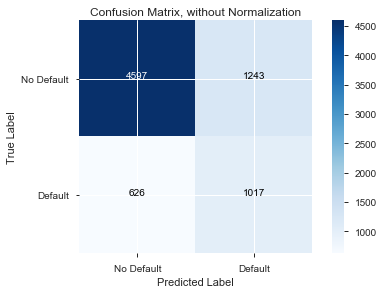

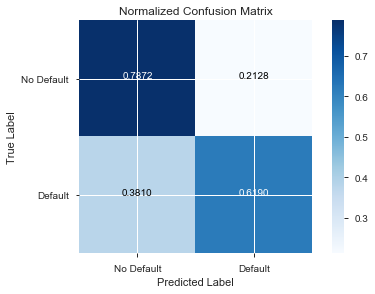

In [122]:
#Logistic Regression Model Tuning
C = [i for i in np.linspace(0.01,2,200)]
penalty = ['l1', 'l2']

gs_lr = GridSearchCV(estimator=LogisticRegression(random_state=42),
                  param_grid=[{'C':C, 'penalty':penalty}], 
                      scoring='accuracy',
                  cv=inner_cv, n_jobs=-1, verbose = 1)

gs_lr = gs_lr.fit(X_cv,Y_cv)
print("[[Parameter Tuning - LR]]")
print("Non-nested CV: ", gs_lr.best_score_)
print("Optimal Parameter: ", gs_lr.best_params_)
print("Optimal Estimator: ", gs_lr.best_estimator_)

#Decision Tree Evaluation
print('The weights of the attributes are:', gs_lr.best_estimator_.fit(X_cv, Y_cv).coef_)
Y_pred = (gs_lr.best_estimator_.fit(X_cv, Y_cv).predict_proba(X_test)[:,1] >= 0.5).astype(bool)
cm1 = confusion_matrix(Y_test, Y_pred)
print('\nModel Performance: '+str((cm1[0][0]+cm1[1][1])/(np.sum(cm1))))
print(classification_report(Y_test, Y_pred, digits=4))

#Class Probability Estimation
cpe_lr = pd.DataFrame(gs_lr.best_estimator_.fit(X_cv, Y_cv).predict_proba(X_test))
cpe_lr['Default'] = Y

#Plot confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=4)

plt.figure()
plot_confusion_matrix(cm, classes=['No Default','Default'],
                      title='Confusion Matrix, without Normalization')

plt.figure()
plot_confusion_matrix(cm, classes=['No Default','Default'], normalize=True,
                      title='Normalized Confusion Matrix')

plt.show()

# Ensemble Test at equal weights

C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)



Model Performance: 0.7499665909394628
              precision    recall  f1-score   support

           0     0.8832    0.7832    0.8302      5840
           1     0.4505    0.6318    0.5260      1643

   micro avg     0.7500    0.7500    0.7500      7483
   macro avg     0.6669    0.7075    0.6781      7483
weighted avg     0.7882    0.7500    0.7634      7483



C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Confusion Matrix, without Normalization
[[4574 1266]
 [ 605 1038]]
Normalized Confusion Matrix
[[0.7832 0.2168]
 [0.3682 0.6318]]


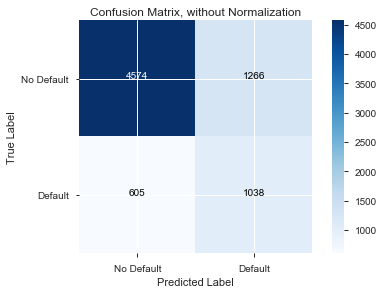

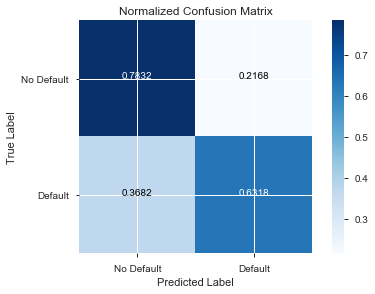

In [123]:
#Ensemble Test
clf1 = eGBT
clf2 = eRF
clf3 = gs_dt.best_estimator_
clf4 = gs_lr.best_estimator_

eclf = VotingClassifier(estimators=[('gbt', clf1), ('rf', clf2), ('dt', clf3), ('lr', clf4)], 
                        voting='soft', weights=[1,1,1,1])

#Weighted Ensemble Valuation
Y_pred = (eclf.fit(X_cv, Y_cv).predict(X_test))
cm1 = confusion_matrix(Y_test, Y_pred)
print('\nModel Performance: '+str((cm1[0][0]+cm1[1][1])/(np.sum(cm1))))
print(classification_report(Y_test, Y_pred, digits=4))

#Class Probability Estimation
cpe_ens = pd.DataFrame(eclf.fit(X_cv, Y_cv).predict_proba(X_test))
cpe_ens['Default'] = Y

#Plot confusion matrix
cm = confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=4)

plt.figure()
plot_confusion_matrix(cm, classes=['No Default','Default'], title='Confusion Matrix, without Normalization')

plt.figure()
plot_confusion_matrix(cm, classes=['No Default','Default'], normalize=True, title='Normalized Confusion Matrix')

plt.show()

# ROC and AUC

K-fold Cross Validation:
ROC AUC: 0.7730 ± 0.0091 [GBT]
ROC AUC: 0.7752 ± 0.0106 [RF]
ROC AUC: 0.7680 ± 0.0037 [DT]


C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC AUC: 0.7747 ± 0.0094 [LR]


C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


ROC AUC: 0.7846 ± 0.0080 [Ens]


C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


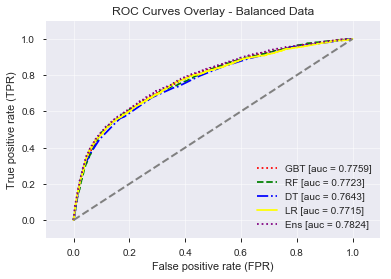

C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


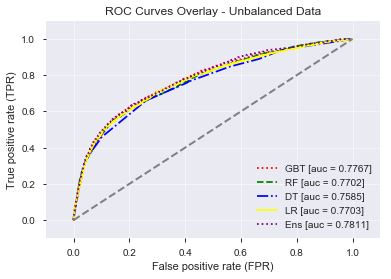

In [124]:
#Label classifiers
clf_labels = ['GBT', 'RF', 'DT', 'LR', 'Ens']
all_clf = [clf1, clf2, clf3, clf4, eclf]

#Printing CV information
print('K-fold Cross Validation:')
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=X_cv, y=Y_cv, cv=5, scoring='roc_auc')
    print("ROC AUC: %0.4f ± %0.4f [%s]" % (scores.mean(), scores.std(), label))

#ROC and AUC, with balanced data sample
colors = ['red', 'green', 'blue', 'yellow', 'purple']
linestyles = [':', '--', '-.', '-', ':', '.-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    Y_pred = clf.fit(X_cv, Y_cv).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=Y_test, y_score=Y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s [auc = %0.4f]' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC Curves Overlay - Balanced Data')
plt.show()

#ROC and AUC, with the entire dataset
colors = ['red', 'green', 'blue', 'yellow', 'purple']
linestyles = [':', '--', '-.', '-', ':', '.-']
for clf, label, clr, ls in zip(all_clf, clf_labels, colors, linestyles):
    Y_pred = clf.fit(X_train, Y_train).predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=Y_test, y_score=Y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr, color=clr, linestyle=ls, label='%s [auc = %0.4f]' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid(alpha=0.5)
plt.xlabel('False positive rate (FPR)')
plt.ylabel('True positive rate (TPR)')
plt.title('ROC Curves Overlay - Unbalanced Data')
plt.show()